In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

In [6]:
df = pd.read_csv('hurricane')
df.head()

,backup,age,bridgecrane,servo,gear,trashrack,slope,elevation,h1,h2,...,h43,h44,h45,h46,h47,h48,survive,hour,reason,reason2
0,0,6.0,0,0,0,1,3,2,1,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1,48,0,5
1,0,6.0,1,0,0,1,7,3,0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1,48,0,5
2,0,6.1,1,0,0,1,3,3,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,48,0,5
3,1,6.1,1,0,0,0,4,3,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,48,0,5
4,0,6.2,1,1,0,1,3,4,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,48,0,5


## Percentage of pumps within each failure type and percentage of pumps that did not fail

In [ ]:
df['reason'].value_counts() / len(df)

reason
0    0.410390
4    0.150649
1    0.149351
2    0.145455
3    0.144156
Name: count, dtype: float64

Reason 0 – no failure occured 41.0390% of the time  
Reason 1 – flood failure occured 14.9351% of the time  
Reason 2 – motor failure occured 14.5455% of the time  
Reason 3 – surge failure occured 0.144156% of the time  
Reason 4 – jammed failure occured 15.0649% of the time

## The average time until failure for each failure type
We should not use means as they are easily skewed, we should instead be using median.

In [ ]:
#sum the binary columns h1:h48 to see how long the pump was observed until censored or failure
df['h_sum'] = df.loc[:, 'h1':'h48'].sum(axis=1)
df.groupby('reason')['h_sum'].agg(['mean', 'median'])

,mean,median
reason,,
0,23.575949,24.5
1,9.626087,5.0
2,20.714286,16.5
3,25.360360,28.0
4,16.543103,9.5


Reason 1 – flood failure occurred 9.6261 hours mean, 5.0 hours median  
Reason 2 – motor failure occurred 20.7143 hours mean, 16.5 hours median  
Reason 3 – surge failure occurred 25.3604 hours mean, 28.0 hours median  
Reason 4 – jammed failure occurred 16.5431 hours mean, 9.5 hours median

## Survival probability across time for pumps broken down by failure type overlaid into one graph

<Axes: xlabel='timeline'>

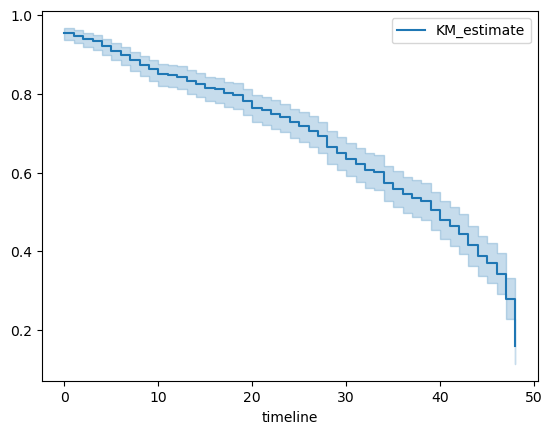

In [41]:
km = KaplanMeierFitter()
km.fit(durations = df['h_sum'],event_observed=df['survive'])
km.survival_function_
km.plot()


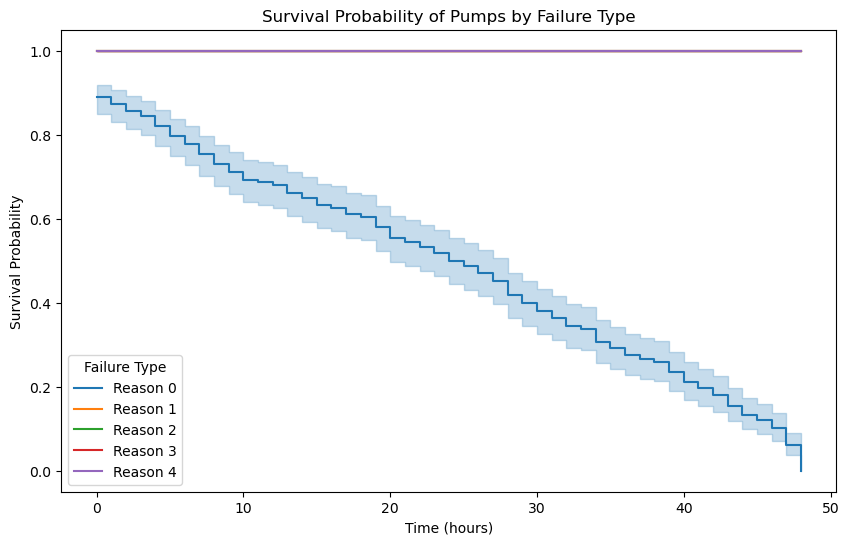

In [46]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

# Loop through each failure type and fit the Kaplan-Meier estimator
for failure_type in df['reason'].unique():
    # Filter data for the specific failure type
    mask = df['reason'] == failure_type
    km.fit(durations=df.loc[mask, 'h_sum'], event_observed=df.loc[mask, 'survive'], label=f"Reason {failure_type}")
    # Plot the survival function for this failure type
    km.plot_survival_function(ax=ax)

# Add labels and title
plt.title('Survival Probability of Pumps by Failure Type')
plt.xlabel('Time (hours)')
plt.ylabel('Survival Probability')
plt.legend(title="Failure Type")
plt.show()